# Time required to load audio

In [1]:
import soundfile
from scipy.io import wavfile

In [2]:
guitar_path = '../data/raw/nsynth-test/audio/guitar_acoustic_021-045-025.wav'
piano_path = '../data/raw/nsynth-train/audio/keyboard_acoustic_013-033-127.wav'

In [3]:
%%timeit -n 1000
soundfile.read(guitar_path)

320 µs ± 87.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
%%timeit -n 1000
wavfile.read(guitar_path)

66 µs ± 9.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Winner: scipy.io.wavfile

# Time required to calculate CQ transform

2015 comparison paper: [An evaluation of audio feature extraction toolboxes](https://www.ntnu.edu/documents/1001201110/1266017954/DAFx-15_submission_43_v2.pdf)

In [5]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from yaafelib import FeaturePlan, Engine, AudioFileProcessor

/usr/local/Caskroom/miniconda/base/envs/deep-music/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [6]:
def load_data(path):
    sr, y = wavfile.read(guitar_path)
    y = y.astype('float64')
    return y, sr

In [7]:
def get_cqt_params(note_resolution=1, nyquist=8000, fmin=32.7, step_size=64000):
    num_octaves = np.log2(nyquist/fmin)
    bins_per_octave = int(12 * note_resolution)
    params = {
        'num_octaves': num_octaves,
        'bins_per_octave': bins_per_octave,
        'n_bins': int(num_octaves * bins_per_octave),
        'fmin': fmin,
        'fmax': nyquist,
        'step_size': step_size
    }
    return params

In [8]:
def plot_cqt(C, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=(20, 7))
    ax.plot(np.log10(C))

In [141]:
def cqt_librosa(audio, sampling_rate, **kwargs):
    params = get_cqt_params(**kwargs)
    C = (np.abs(librosa.cqt(
        y=audio,
        sr=sampling_rate,
        fmin=params['fmin'],
        n_bins=params['n_bins'],
        bins_per_octave=params['bins_per_octave'],
        hop_length=params['step_size'],
        scale=False,
        sparsity=0,     # slower
        res_type='fft', # slower
    )))
    return C

In [142]:
def cqt_yaafe(audio, sampling_rate, **kwargs):
    params = get_cqt_params(**kwargs)
    cqt_feature = {
        'CQTAlign': 'c',
        'CQTBinsPerOctave': params['bins_per_octave'],
        'CQTMinFreq': params['fmin'],
        'CQTNbOctaves': params['num_octaves'],
        'stepSize': params['step_size']
    }
    fp = FeaturePlan(sampling_rate)
    fp.addFeature('cqt: CQT ' + ' '.join([f'{k}={v}' for k, v in cqt_feature.items()]))
    df = fp.getDataFlow()
    engine = Engine()
    engine.load(df)
    C = engine.processAudio(audio)['cqt']
    return C

In [157]:
def cqt_essentia():
    """This package couldn't even install"""
    pass

In [143]:
audio, sampling_rate = load_data(guitar_path)
audio_yaafe = audio.reshape(1, -1)

In [153]:
%%timeit -n 10
cqt_librosa(audio, sampling_rate, note_resolution=10)

187 ms ± 25.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [158]:
%%timeit -n 10
cqt_yaafe(audio_yaafe, sampling_rate, note_resolution=10)

141 ms ± 9.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Visualise output

## Librosa

(476, 2)
(1904, 2)
(4760, 2)


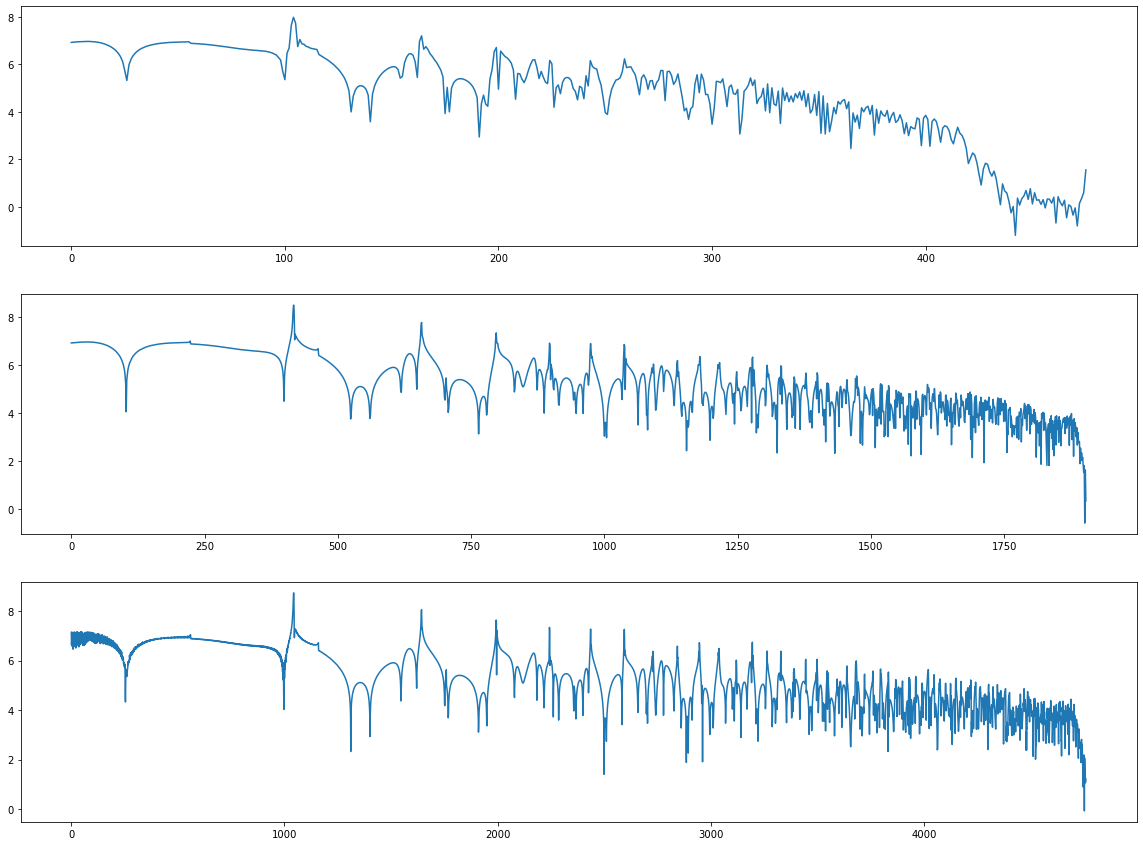

In [152]:
# Librosa
resolutions = [5, 20, 50]
num_res = len(resolutions)
fig, axes = plt.subplots(num_res, 1, figsize=(20, 5*num_res))

for res, ax in zip(resolutions, axes):
    C = cqt_librosa(audio, sampling_rate, note_resolution=res)
    print(C.shape)
    plot_cqt(C[:, 0], ax)

## YAAFElib

This output looks wrong - some lower frequencies are chopped off

YAAFE is also out of date, has very few features and is rarely maintained

(2, 420)
(2, 1680)
(2, 4200)


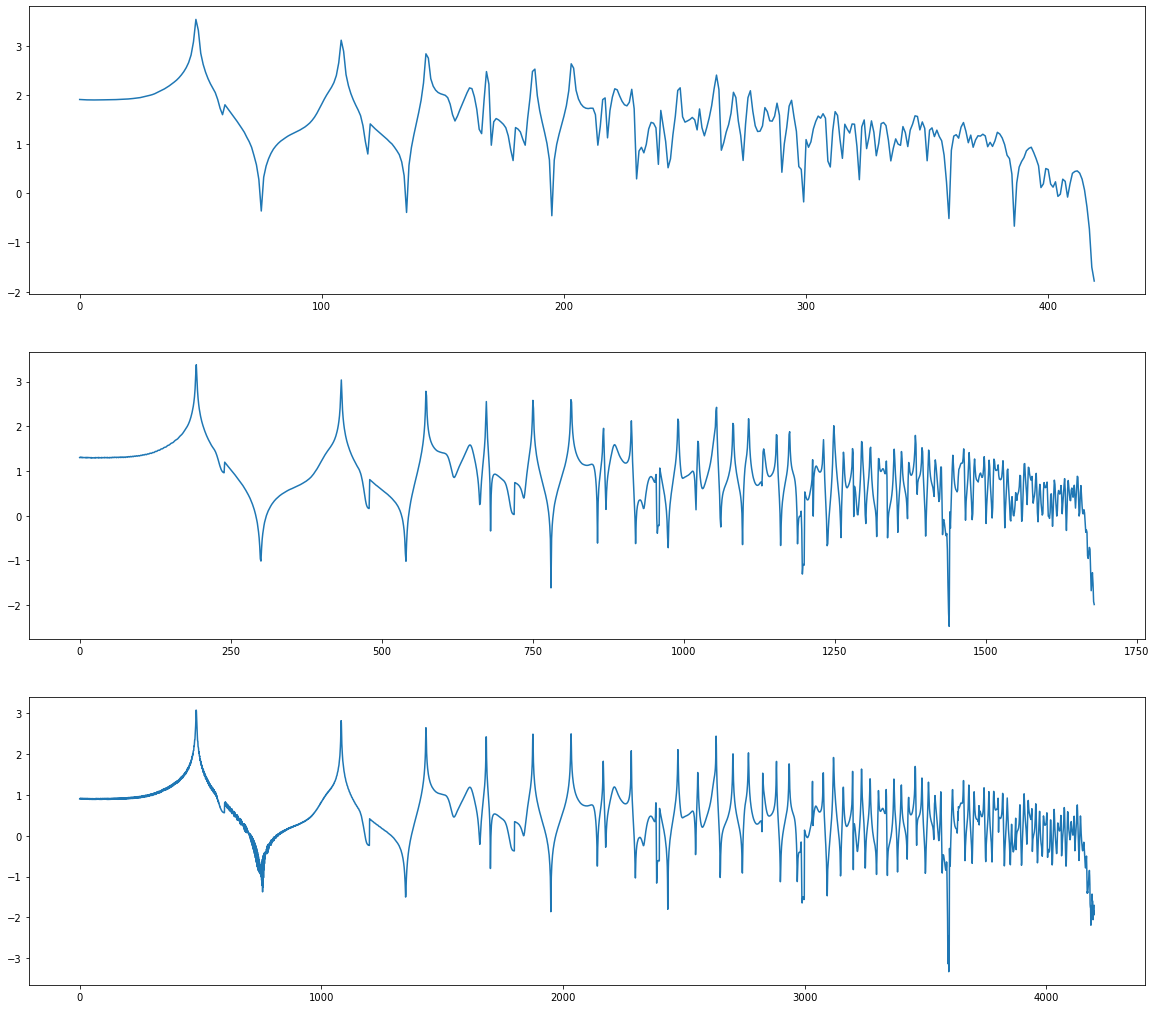

In [155]:
# YAAFE
resolutions = [5, 20, 50]
num_res = len(resolutions)
fig, axes = plt.subplots(num_res, 1, figsize=(20, 6*num_res))

for res, ax in zip(resolutions, axes):
    C = cqt_yaafe(audio_yaafe, sampling_rate, note_resolution=res)
    print(C.shape)
    plot_cqt(C[0, :], ax)

Winner: librosa